In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [233]:
def process_caffe_log(logfname,epoch_size):
    print "processing caffe logs"
    result = {}
    
    import re
    trainiter = re.compile('I(\d\d\d\d\s+\d\d\:\d\d\:\d\d\.\d+)\s+\d+\s+solver\.cpp\:\d+\]\s+Iteration\s+(\d+),\s+loss\s+=\s+(\d+\.\d+)')
    trainnetloss3 = re.compile('I(\d+\s+\d+\:\d+\:\d+\.\d+)\s+\d+\s+solver\.cpp\:\d+\]\s+Train\s+net\s+output\s+#\d\:\s+loss3\/loss\s+=\s+(\d+.\d+)*')
    trainiterlr = re.compile('I(\d+\s+\d+\:\d+\:\d+\.\d+)\s+\d+\s+sgd_solver\.cpp\:\d+\]\s+Iteration\s+(\d+),\s+lr\s+=\s+(\d+\.\d+)')
    testiter = re.compile('I(\d+\s+\d+\:\d+\:\d+.\d+\s+\d+)\s+solver\.cpp\:\d+\]\s+Iteration\s+(\d+),\s+Testing\s+net\s+\(#0\)')
    testnettop1 = re.compile('I(\d+\s+\d+\:\d+\:\d+\.\d+)\s+\d+\s+solver\.cpp\:\d+\]\s+Test\s+net\s+output\s+#\d+\:\s+loss3\/top-1\s+=\s+(\d+\.\d+)\s*')
    testnettop5 = re.compile('I(\d+\s+\d+\:\d+\:\d+\.\d+)\s+\d+\s+solver\.cpp\:\d+\]\s+Test\s+net\s+output\s+#\d+\:\s+loss3\/top-5\s+=\s+(\d+\.\d+)\s*')
    with open(logfname) as log:
        contents = log.readlines()
        print len(contents)," of log lines to process"
        print "Start Processing Logs..."
        cur_iter = 0
        for log in contents:
            trainiterm = trainiter.match(log)
            trainnetloss3m = trainnetloss3.match(log)
            trainiterlrm = trainiterlr.match(log)
            testiterm = testiter.match(log)
            testnettop1m = testnettop1.match(log)
            testnettop5m = testnettop5.match(log)
            if trainiterm or testiterm:
                #print trainiterm.groups()
                cur_iter = eval(trainiterm.group(2) if trainiterm else testiterm.group(2))
                result[cur_iter] = result.get(cur_iter,{})
                #print "current iteration = ",cur_iter
            elif trainiterlrm :
                result[eval(trainiterlrm.group(2))]['lr'] = eval(trainiterlrm.group(3))
            elif trainnetloss3m:
                result[cur_iter]['trainloss3'] = eval(trainnetloss3m.group(2))
            elif testnettop1m :
                result[cur_iter]['testtop1'] = eval(testnettop1m.group(2))
            elif testnettop5m :
                result[cur_iter]['testtop5'] = eval(testnettop5m.group(2))
            else :
                #print "log doesn't match any of the patterns: ",log
                pass
        print "Done Log Processing."
        
        #prepare ndarrays for plotting
        train_tbl = np.zeros((3,len(result.keys()))) #iter,trainloss3
        test_tbl = np.zeros((5,len(result.keys()))) #iter,lr,trainloss3,testtop1,testtop5
        test_tbl_epoch = np.zeros((5,999))
        #print result
        #get all test results with train lr
        idx_train = 0
        idx_test = 0
        idx_test_epoch = 0
        for iter,values in sorted(result.items()):
            #print iter,values
            if values.has_key('trainloss3'):
                train_tbl[0][idx_train] = iter
                train_tbl[1][idx_train] = values['lr']
                train_tbl[2][idx_train] = values['trainloss3']
                idx_train = idx_train + 1
            if values.has_key('testtop1'):
                #print iter,values
                test_tbl[0][idx_test] = iter
                test_tbl[1][idx_test] = values.get('lr',0)
                test_tbl[2][idx_test] = values.get('trainloss3',0)
                test_tbl[3][idx_test] = values['testtop1']
                test_tbl[4][idx_test] = values['testtop5']
                idx_test = idx_test + 1
                if iter%epoch_size == 0:
                    test_tbl_epoch[0][idx_test_epoch] = int(iter/epoch_size)
                    test_tbl_epoch[1][idx_test_epoch] = values.get('lr',0)
                    test_tbl_epoch[2][idx_test_epoch] = values.get('trainloss3',0)
                    test_tbl_epoch[3][idx_test_epoch] = values['testtop1']
                    test_tbl_epoch[4][idx_test_epoch] = values['testtop5']
                    idx_test_epoch = idx_test_epoch + 1
        print test_tbl_epoch[:,0:idx_test_epoch].shape[1],'epochs with data found'
        #return the errs, top1 accuracy and the last epoch and last iteration
        return train_tbl[:,0:idx_train],test_tbl[:,0:idx_test],test_tbl_epoch[:,0:idx_test_epoch],idx_test_epoch,iter%epoch_size

In [234]:
tests = [
    ('256-step','/home/user/shane/caffe/yiheng-googlenetv2-bs32x8-8GPU.log',128*10000/256),
    ('512-triangular2','/home/user/shane/caffe/gv2-bs64x8-8GPU-tri2.log',128*10000/512),
    ('32-step','/home/user/shane/caffe/yiheng-googlenetv2-bs32-1GPU.log',128*10000/32),
    ]
result_tbls = []
for (label,log,epoch_size) in tests:
    print 'TEST ===',label,'==='
    print log
    train1,test1,test1_epoch,last_epoch,last_it = process_caffe_log(log,epoch_size)
    result_tbls.append({'label':label,'train_result':train1,'test_result':test1,'test_result_epoch':test1_epoch})
    #print test1[0,:]

TEST === 256-step ===
/home/user/shane/caffe/yiheng-googlenetv2-bs32x8-8GPU.log
processing caffe logs
138931  of log lines to process
Start Processing Logs...
Done Log Processing.
102 epochs with data found
TEST === 512-triangular2 ===
/home/user/shane/caffe/gv2-bs64x8-8GPU-tri2.log
processing caffe logs
10754  of log lines to process
Start Processing Logs...
Done Log Processing.
20 epochs with data found
TEST === 32-step ===
/home/user/shane/caffe/yiheng-googlenetv2-bs32-1GPU.log
processing caffe logs
170372  of log lines to process
Start Processing Logs...
Done Log Processing.
30 epochs with data found


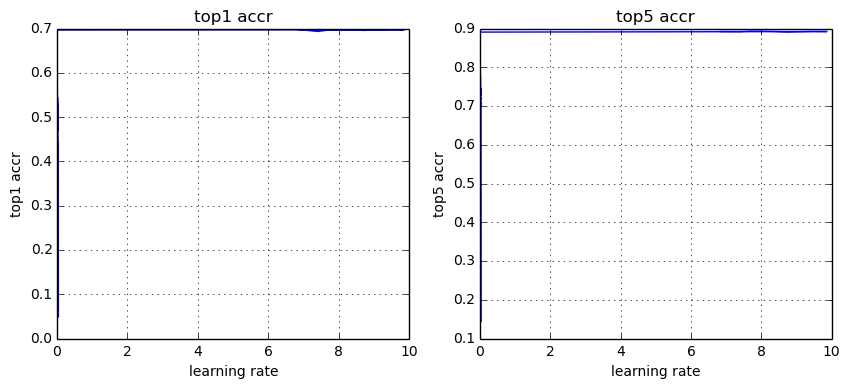

In [215]:
#plot learning rate - accuracy
plt.figure(1,figsize=(10, 4))
plt.subplot(121)
plt.title('top1 accr')
plt.plot(result_tbls[0]['test_result'][1,:],result_tbls[0]['test_result'][3,:])
plt.grid(True)
plt.xlabel('learning rate')
plt.ylabel('top1 accr')
plt.figure(1,figsize=(10, 4))
plt.subplot(122)
plt.title('top5 accr')
plt.plot(result_tbls[0]['test_result'][1,:],result_tbls[0]['test_result'][4,:])
plt.grid(True)
plt.xlabel('learning rate')
plt.ylabel('top5 accr')

In [240]:
#### formattings
def plot_formats(num):
    #from itertools import cycle
    #lines = ["-","--"]
    #linecycler = cycle(lines)    
    lwidths = np.linspace(1,4,num)
    formats = [{'lw':lw} for lw in lwidths]
    return formats

TEST MAX ACCURACY: 256-step
maxiter_top1 =  1020000.0 top1acc = 0.697875 top5acc = 0.892313
maxiter_top5 =  1000000.0 top1acc = 0.696563 top5acc = 0.893281
TEST MAX ACCURACY: 512-triangular2
maxiter_top1 =  100000.0 top1acc = 0.568062 top5acc = 0.813375
maxiter_top5 =  100000.0 top1acc = 0.568062 top5acc = 0.813375
TEST MAX ACCURACY: 32-step
maxiter_top1 =  1200000.0 top1acc = 0.712969 top5acc = 0.902656
maxiter_top5 =  1190000.0 top1acc = 0.709594 top5acc = 0.904813


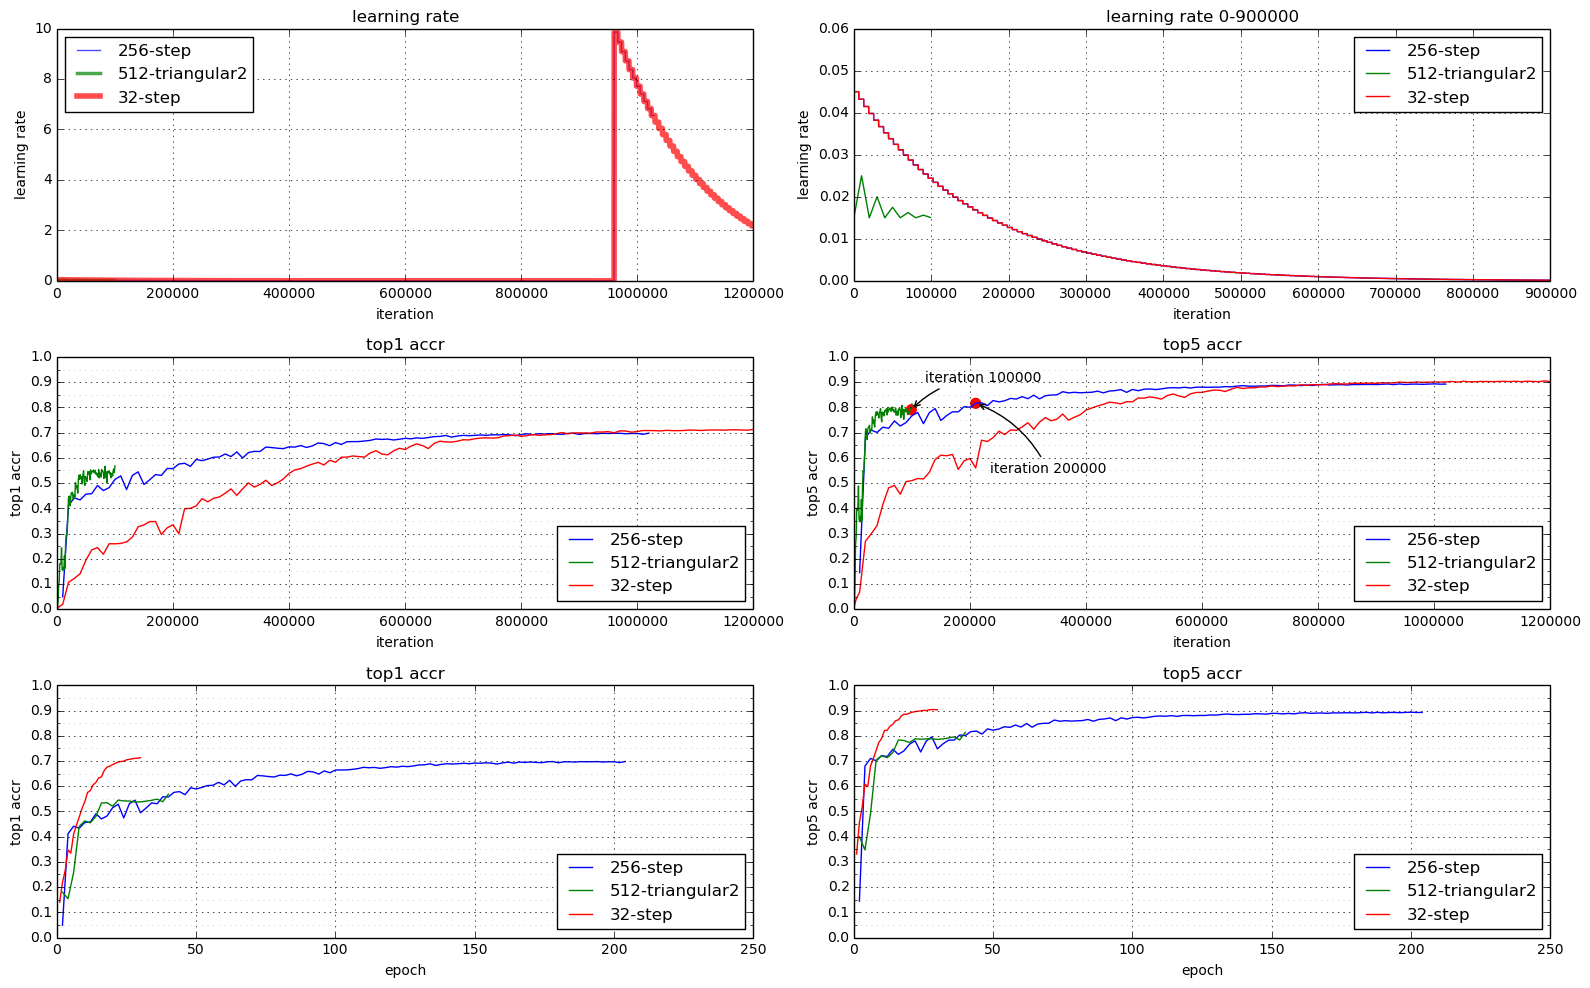

In [243]:
lineformats = plot_formats(len(result_tbls))
#plot the learning curve of one epoch
plt.figure(1,figsize=(16,10))
major_ticks = np.arange(0, 1.01, 0.1)                                              
minor_ticks = np.arange(0, 1.01, 0.05)
#plot the error
ax=plt.subplot(321)
plt.title('learning rate')
for result,lineformat in zip(result_tbls,lineformats):
    plt.plot(result['train_result'][0,:],result['train_result'][1,:],label=result['label'],linewidth=lineformat['lw'],alpha=0.7)
ax.legend(loc='upper left')
plt.grid(True)
plt.xlabel('iteration')
plt.ylabel('learning rate')

ax=plt.subplot(322)
plt.title('learning rate 0-900000')
for result in result_tbls:
    plt.plot(result['train_result'][0,:],result['train_result'][1,:],label=result['label'])
ax.legend(loc='upper right')
plt.grid(True)
plt.xlabel('iteration')
plt.ylabel('learning rate')
plt.xlim((0,900000))
plt.ylim((0,0.06))

#plot the error
ax=plt.subplot(323)
ax.set_yticks(major_ticks)                                                       
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
ax.grid(which='minor', alpha=0.2)                                                
plt.title('top1 accr')
for result in result_tbls:
    plt.plot(result['test_result'][0,:],result['test_result'][3,:],label=result['label'])
ax.legend(loc='lower right')
plt.grid(True)
plt.xlabel('iteration')
plt.ylabel('top1 accr')
plt.ylim((0,1))
plt.xlim(xmin=0)

#plot the error
ax=plt.subplot(324)
ax.set_yticks(major_ticks)                                                       
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
ax.grid(which='minor', alpha=0.2)                                                
plt.title('top5 accr')
for result in result_tbls:
    plt.plot(result['test_result'][0,:],result['test_result'][4,:],label=result['label'])
ax.legend(loc='lower right')
plt.grid(True)
plt.ylim((0,1))
plt.xlim(xmin=0)
#=========== annotation begin ===========
#the spot on 256-step
spot=(result_tbls[0]['test_result'][0,20],result_tbls[0]['test_result'][4,20])
plt.scatter([spot[0], ], [spot[1], ], 50, color='red')
plt.annotate(r'iteration 200000',
             xy=(spot[0], spot[1]), xycoords='data',
             xytext=(+10, -50), textcoords='offset points', fontsize=10,
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))
#the spot on 512-triangular2
spot=(result_tbls[1]['test_result'][0,98],result_tbls[1]['test_result'][4,98])
plt.scatter([spot[0], ], [spot[1], ], 50, color='red')
plt.annotate(r'iteration 100000',
             xy=(spot[0], spot[1]), xycoords='data',
             xytext=(+10, +20), textcoords='offset points', fontsize=10,
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))
#=========== annotation end ===========
plt.xlim(xmin=0)
plt.xlabel('iteration')
plt.ylabel('top5 accr')

#plot the error
ax=plt.subplot(325)
ax.set_yticks(major_ticks)                                                       
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
ax.grid(which='minor', alpha=0.2)                                                
plt.title('top1 accr')
for result in result_tbls:
    plt.plot(result['test_result_epoch'][0,:],result['test_result_epoch'][3,:],label=result['label'])
ax.legend(loc='lower right')
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel('top1 accr')
plt.ylim((0,1))
plt.xlim(xmin=0)

#plot the error
ax=plt.subplot(326)
ax.set_yticks(major_ticks)                                                       
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
ax.grid(which='minor', alpha=0.2)                                                
plt.title('top5 accr')
for result in result_tbls:
    plt.plot(result['test_result_epoch'][0,:],result['test_result_epoch'][4,:],label=result['label'])
ax.legend(loc='lower right')
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel('top5 accr')
plt.ylim((0,1))
plt.xlim(xmin=0)
plt.tight_layout()

for result in result_tbls:
    print 'TEST MAX ACCURACY:',result['label']
    am = result['test_result'].max(axis=1)
    maxind = result['test_result'].argmax(axis=1)
    print 'maxiter_top1 = ',result['test_result'][0,maxind[3]],'top1acc =',result['test_result'][3,maxind[3]],'top5acc =',result['test_result'][4,maxind[3]]
    print 'maxiter_top5 = ',result['test_result'][0,maxind[4]],'top1acc =',result['test_result'][3,maxind[4]],'top5acc =',result['test_result'][4,maxind[4]]